# Oxford Pets - Multiclass Segmentation

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import torch
import torch.nn as nn
import torchvision

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from pt_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from pt_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

## Parameters

In [3]:
use_cpu = False
use_cuda = not use_cpu and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)

cuda


In [4]:
image_size = (224, 224)
batch_size = 30

In [5]:
save_weights = False
weights_name = "./pt_models/pt_oxford-pets_seg-3_unet.pth"

## Data Set

In [6]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths


def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [7]:
def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

In [8]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "annotations", "trimaps")

image_paths = get_paths(image_dir, formats=['jpg'])
labels = get_labels(image_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(image_paths)}")
print(">> Class Names:", class_names)

>> Images: 7378
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [10]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_mask_paths = change_paths(mask_dir, train_image_paths, replace=['jpg', 'png'])
valid_mask_paths = change_paths(mask_dir, valid_image_paths, replace=['jpg', 'png'])
test_mask_paths = change_paths(mask_dir, test_image_paths, replace=['jpg', 'png'])

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 4426 (0.60)
>> Valid images: 1476 (0.20)
>> Test  images: 1476 (0.20)


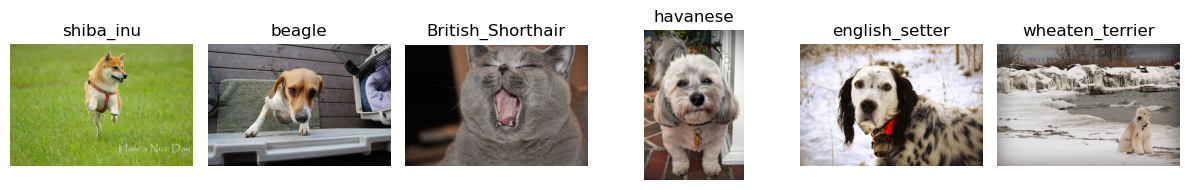

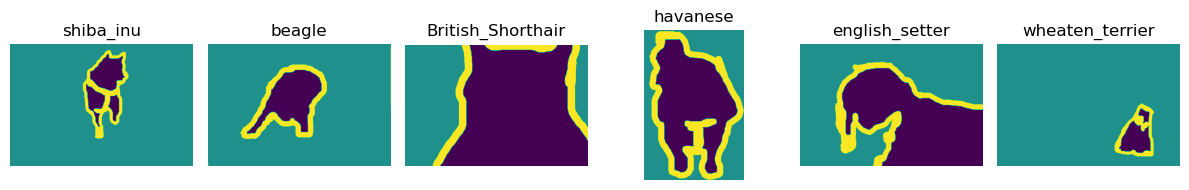

In [11]:
n_samples = 6
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)
show_images(train_mask_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)

## Data Loader

In [24]:
import cv2
import albumentations as A

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, training=False):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = train_transform if training else valid_transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
       
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"]
        
        image = torch.tensor(image).permute(2, 0, 1).float()/255 # [0, 255] -> [0, 1]
        mask -= 1
        mask = torch.tensor(mask).long()
        return image, mask


train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, rotate_limit=15,),
    A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
                    max_width=int(0.1*image_size[1])),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

train_loader = torch.utils.data.DataLoader(
        Dataset(train_image_paths, train_mask_paths, training=True), 
        batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(
        Dataset(valid_image_paths, valid_mask_paths, training=False), 
        batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
        Dataset(test_image_paths, test_mask_paths, training=False), 
        batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

<class 'torch.Tensor'> torch.Size([30, 3, 224, 224]) torch.float32
<class 'torch.Tensor'> torch.Size([30, 224, 224]) torch.int64
>> Images: min: 0.0, max: 1.0
>> Labels: min: 0, max: 2


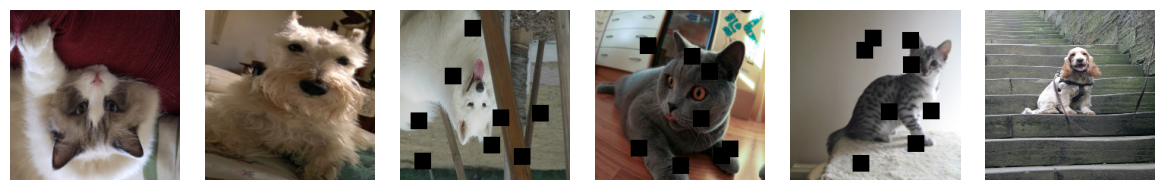

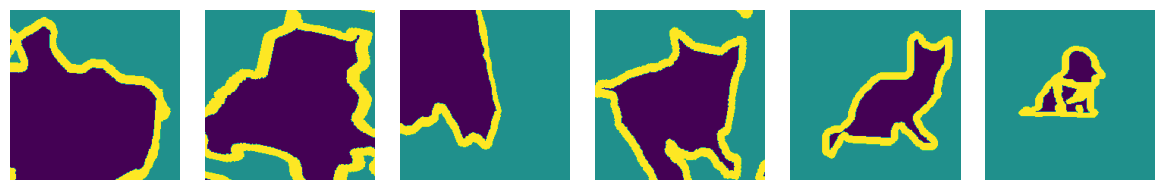

In [25]:
images, masks = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(masks), masks.shape, masks.dtype)

images = images.permute(0, 2, 3, 1).numpy()
masks = masks.numpy()

n_samples = 6
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> Labels: min: {masks.min()}, max: {masks.max()}")

show_images(images[:n_samples], n_cols=n_samples)
show_images(masks[:n_samples], n_cols=n_samples)

### Modeling

In [ ]:
# print(torch.__version__)
# print(torchvision.__version__)
# dir(torchvision.models)

In [26]:
def conv_block(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),)
    return block


def upsampling(in_channels, out_channels):
    block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            # nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),

            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),)
    return block


class CustomUnet(nn.Module):
    def __init__(self, in_channels, out_channels, filters=[32, 64, 128, 256]):
        super().__init__()

        self.encode1 = conv_block(in_channels, filters[0])
        self.encode2 = conv_block(filters[0], filters[1])
        self.encode3 = conv_block(filters[1], filters[2])
        self.encode4 = conv_block(filters[2], filters[3])
        self.downsample = nn.MaxPool2d(kernel_size=2)
        
        self.bridge = conv_block(filters[3], filters[3]*2)
        
        self.upsample1 = upsampling(filters[3]*2, filters[3])
        self.decode1 = conv_block(filters[3]*2, filters[3])
        
        self.upsample2 = upsampling(filters[3], filters[2])
        self.decode2 = conv_block(filters[3], filters[2])
        
        self.upsample3 = upsampling(filters[2], filters[1])
        self.decode3 = conv_block(filters[2], filters[1])

        self.upsample4 = upsampling(filters[1], filters[0])
        self.decode4 = conv_block(filters[1], filters[0])
        
        self.output_layer = nn.Conv2d(filters[0], out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        ## Encoding
        features = []
        encoding_layers = [self.encode1, self.encode2, self.encode3, self.encode4]
        for encode in encoding_layers:
            x = encode(x)
            features.append(x)
            x = self.downsample(x)

        ## Bridge
        x = self.bridge(x)

        ## Decoding
        upsamplers = [self.upsample1, self.upsample2, self.upsample3, self.upsample4]
        decoding_layers = [self.decode1, self.decode2, self.decode3, self.decode4]
        for upsample, decode, feature in zip(upsamplers, decoding_layers, features[::-1]):
            x = upsample(x)
            x = torch.cat([x, feature], dim=1)
            x = decode(x)

        outputs = self.output_layer(x)
        return outputs

In [31]:
from pt_trainer import iou, dice_coeff, MulticlassIOU, MulticlassDiceCoeff

def ce_dice_loss(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    dice_coeff = MulticlassDiceCoeff(n_classes=4)
    dice_loss = 1 - dice_coeff(y_pred, y_true)
    return ce_loss + dice_loss

In [28]:
unet = CustomUnet(in_channels=3, out_channels=3)
x = torch.randn(1, 3, 224, 224)
out = unet(x)

out.shape

torch.Size([1, 3, 224, 224])

## Training

In [32]:
%%time
model = CustomUnet(in_channels=3, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = ce_dice_loss
metrics={'dice': MulticlassDiceCoeff(n_classes=4),
         'iou': MulticlassIOU(n_classes=4),
         'acc': accuracy}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=5, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" for key, value in results.items()]))

Epoch[  1/  5] loss=1.3617, dice=0.3286, iou=0.2629, acc=0.7188 | val_loss=1.2309, val_dice=0.3849, val_iou=0.3057, val_acc=0.7568 (1)
Epoch[  2/  5] loss=1.1378, dice=0.4073, iou=0.3270, acc=0.7852 | val_loss=1.0458, val_dice=0.4239, val_iou=0.3461, val_acc=0.8144 (1)
Epoch[  3/  5] loss=1.0419, dice=0.4386, iou=0.3560, acc=0.8119 | val_loss=1.2198, val_dice=0.4270, val_iou=0.3422, val_acc=0.7679 (2)
Epoch[  4/  5] loss=0.9743, dice=0.4608, iou=0.3780, acc=0.8300 | val_loss=0.9331, val_dice=0.4655, val_iou=0.3857, val_acc=0.8481 (1)
Epoch[  5/  5] loss=0.9252, dice=0.4755, iou=0.3936, acc=0.8437 | val_loss=0.8944, val_dice=0.4867, val_iou=0.4062, val_acc=0.8535 (1)
>> test_loss=0.9167, test_dice=0.4820, test_iou=0.4007, test_acc=0.8471                             
CPU times: user 4min 32s, sys: 43.3 s, total: 5min 15s
Wall time: 5min 14s


In [ ]:
# if save_weights:
#     torch.save(model, weights_name)

## Inference

In [ ]:
# if save_weights:
#     model = CustomUnet(in_channels=3, out_channels=3).to(device)
#     model.load_state_dict(torch.load(weights_name))

>> Ground Truth:


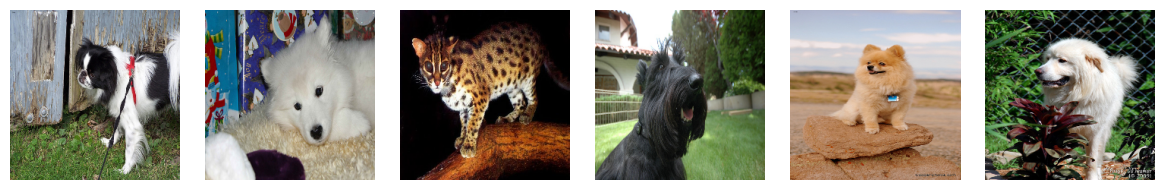

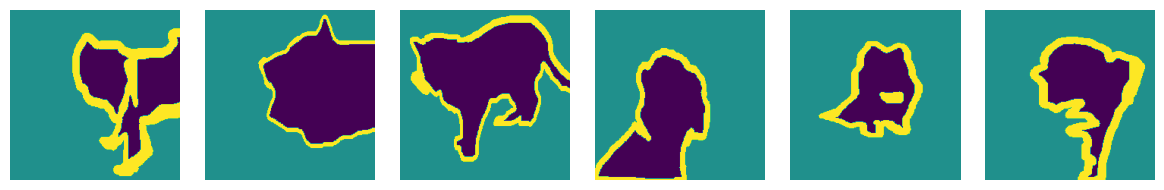

>> Predictions:


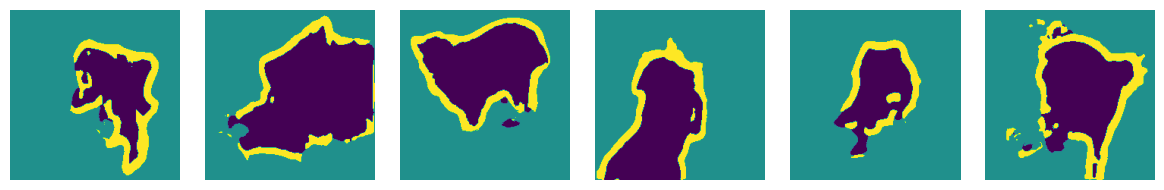

In [33]:
images, masks = next(iter(test_loader))

model.eval()
preds = model(images.to(device)).detach().cpu()

images = images.permute(0, 2, 3, 1).numpy()
masks = masks.numpy()
preds = softmax(preds.numpy()).argmax(axis=1)

n_samples = 6
print(">> Ground Truth:")
show_images(images[:n_samples], n_cols=n_samples)
show_images(masks[:n_samples], n_cols=n_samples)

print(">> Predictions:")
show_images(preds[:n_samples], n_cols=n_samples)